##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optical Tomography Coherence Image classification for the detection of degenerative diseases.

## The objective of this project is to be presented as my MSC thesis

This tutorial shows how to classify Degenerative ocular diseases from images. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.We can get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

Let's start by importing the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python list to numpy array and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and validation data.

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

This data-set was generated by procesing thousands of images obtained from Kaggle - <a href="https://www.kaggle.com/paultimothymooney/kermany2018" target="_blank">Retinal OCT Images (optical coherence tomography)</a> from , the processing allowed me to clean the images from unwanted regions, remove noise in the images and get a crisper image to feed my classifier.

The Jupyter Notebook for the image processor can be found here <a href="https://github.com/luiscrodriguez/OCT/blob/master/ImageProcessing.ipynb" target="_blank">Image Processing Notebook</a>

In order to be able to use the Jupyter notebook you will also requiere to import <a href="https://github.com/luiscrodriguez/OCT/blob/master/imagepro.py" target="_blank">imagepro.py</a> into your code.

In [4]:
PATH = 'DATA-OTSY'

The dataset has the following directory structure:

<pre>
<b>DATA</b>
|__ <b>train</b>
    |______ <b>NORMAL</b>: [FILES.JPEG]
    |______ <b>DME</b>   : [FILES.JPEG]
    |______ <b>DRUSEN</b>: [FILES.JPEG]
    |______ <b>CNV</b>   : [FILES.JPEG]
|__ <b>validation</b>
    |______ <b>NORMAL</b>: [FILES.JPEG]
    |______ <b>DME</b>   : [FILES.JPEG]
    |______ <b>DRUSEN</b>: [FILES.JPEG]
    |______ <b>CNV</b>   : [FILES.JPEG]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

In [6]:
train_categories = {'CNV','NORMAL','DRUSEN','DME'}

directories = []
for element in train_categories:
    directories.append([element, os.path.join(validation_dir, element), os.path.join(train_dir, element)])

print(directories)

[['NORMAL', 'DATA-OTSY\\test\\NORMAL', 'DATA-OTSY\\train\\NORMAL'], ['DRUSEN', 'DATA-OTSY\\test\\DRUSEN', 'DATA-OTSY\\train\\DRUSEN'], ['DME', 'DATA-OTSY\\test\\DME', 'DATA-OTSY\\train\\DME'], ['CNV', 'DATA-OTSY\\test\\CNV', 'DATA-OTSY\\train\\CNV']]


### Understand the data

Let's look at how many images are in the training and validation directory:

In [7]:
total_train = 0  
total_val = 0
for type, val, train in directories:
    total_train = total_train+ len(os.listdir(train))
    total_val = total_val + len(os.listdir(val))
    
    print('Total {} training images:'.format(type), len(os.listdir(train)))
    print('Total {} validation images:'.format(type), len(os.listdir(val)))
    print('')
    
print('Total training images:', total_train)
print('Total validation images:',total_val)

Total NORMAL training images: 26315
Total NORMAL validation images: 242

Total DRUSEN training images: 8616
Total DRUSEN validation images: 242

Total DME training images: 11348
Total DME validation images: 242

Total CNV training images: 37205
Total CNV validation images: 242

Total training images: 83484
Total validation images: 968


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [9]:
batch_size = 128
epochs = 8
IMG_HEIGHT = 200
IMG_WIDTH = 200

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 83484 images belonging to 4 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 968 images belonging to 4 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [13]:
sample_training_images, _= next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

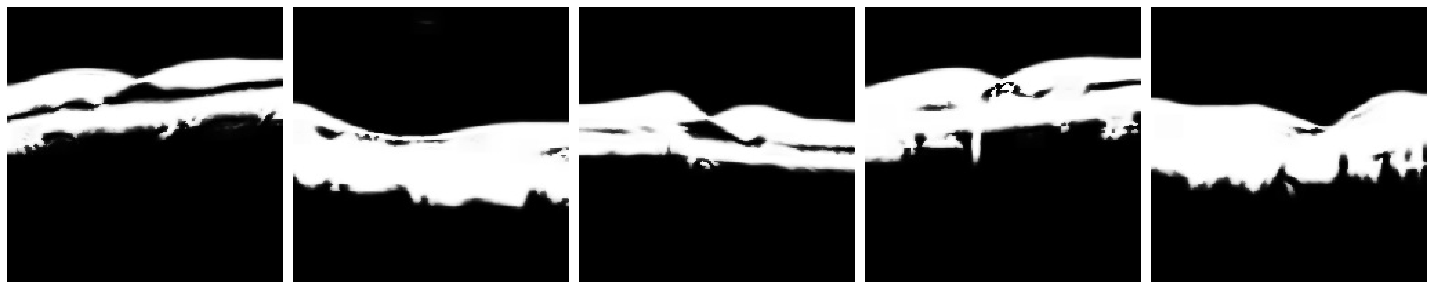

In [15]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [16]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4)
])

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [19]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 652 steps, validate for 7 steps
Epoch 1/8
652/652 [==============================] - 1647s 3s/step - loss: 0.2855 - accuracy: 0.8763 - val_loss: 0.2544 - val_accuracy: 0.8803
Epoch 2/8
652/652 [==============================] - 1500s 2s/step - loss: 0.1790 - accuracy: 0.9239 - val_loss: 0.1960 - val_accuracy: 0.9205
Epoch 3/8
652/652 [==============================] - 1405s 2s/step - loss: 0.1216 - accuracy: 0.9497 - val_loss: 0.1485 - val_accuracy: 0.9523
Epoch 4/8
652/652 [==============================] - 1568s 2s/step - loss: 0.0722 - accuracy: 0.9717 - val_loss: 0.1558 - val_accuracy: 0.9609
Epoch 5/8
652/652 [==============================] - 1453s 2s/step - loss: 0.0383 - accuracy: 0.9870 - val_loss: 0.2116 - val_accuracy: 0.9517
Epoch 6/8
652/652 [==============================] - 1385s 2s/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.2099 - val_accuracy: 0.9621
Epoch 7/8
652/652 [==============================]

### Visualize training results

Now visualize the results after training the network.

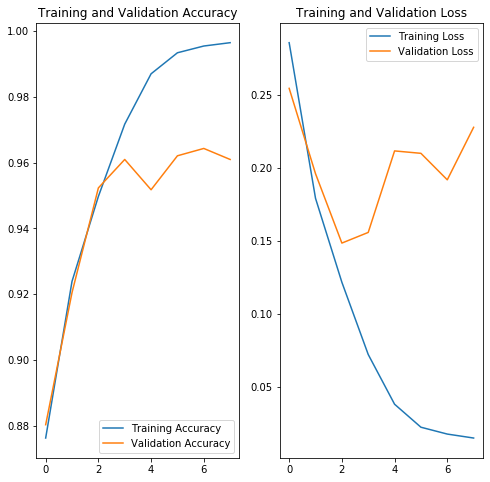

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

Let's look at what went wrong and try to increase overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [21]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [22]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 83484 images belonging to 4 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

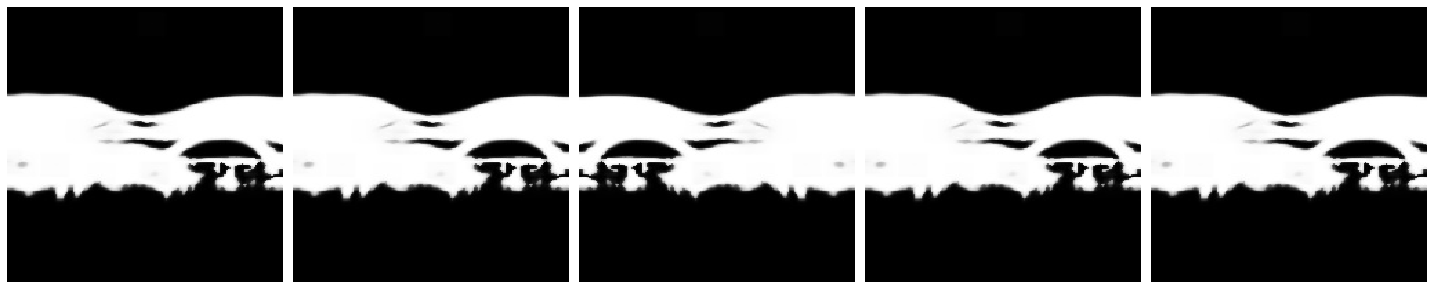

In [24]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [26]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 83484 images belonging to 4 classes.


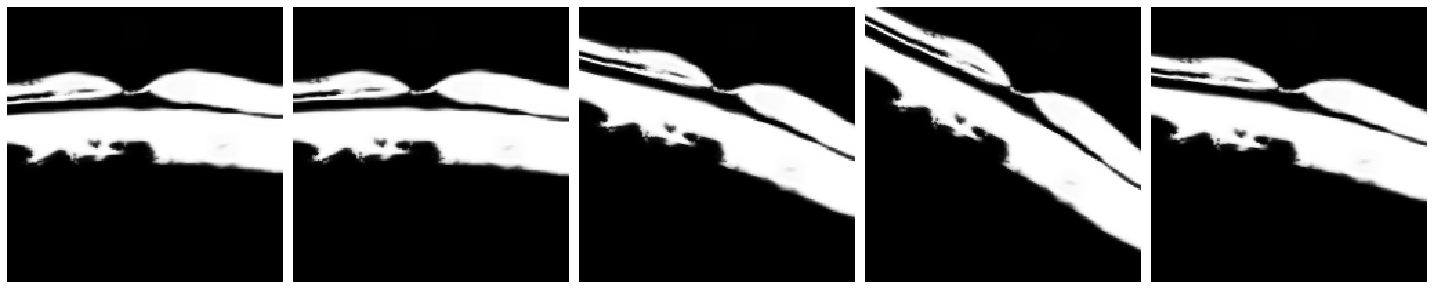

In [27]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [28]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [29]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 83484 images belonging to 4 classes.


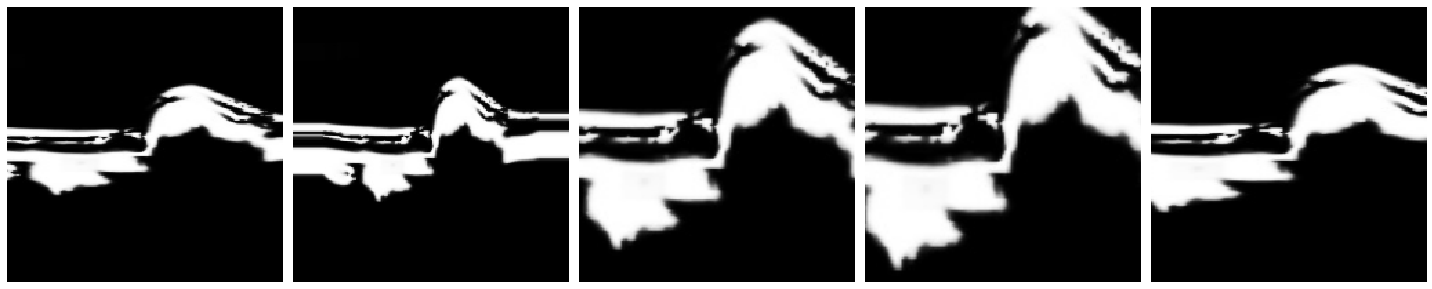

In [30]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [31]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [32]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 83484 images belonging to 4 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

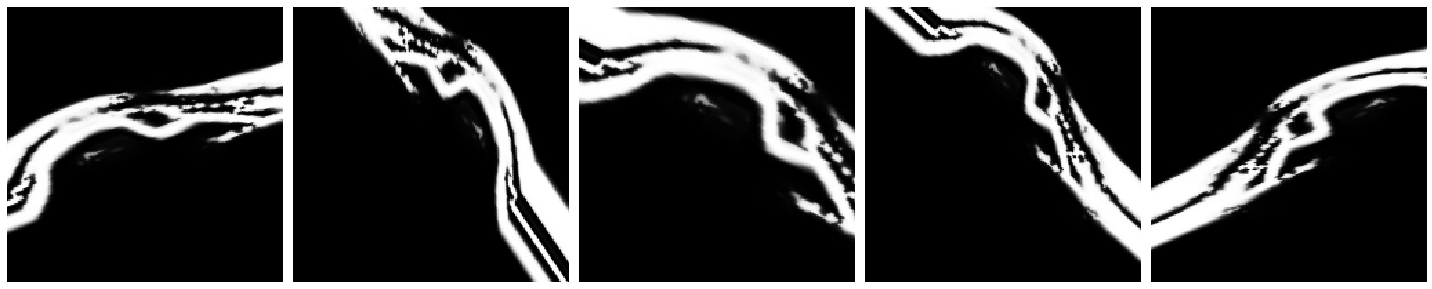

In [33]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [34]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [35]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 968 images belonging to 4 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [36]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [37]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [38]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=6,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 652 steps, validate for 7 steps
Epoch 1/6
652/652 [==============================] - 1788s 3s/step - loss: 0.5749 - accuracy: 0.7500 - val_loss: 0.5636 - val_accuracy: 0.7500
Epoch 2/6
652/652 [==============================] - 1790s 3s/step - loss: 0.5624 - accuracy: 0.7500 - val_loss: 0.5635 - val_accuracy: 0.7500
Epoch 3/6
652/652 [==============================] - 2300s 4s/step - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.5634 - val_accuracy: 0.7500
Epoch 4/6
652/652 [==============================] - 1888s 3s/step - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.5632 - val_accuracy: 0.7500
Epoch 5/6
652/652 [==============================] - 1791s 3s/step - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.5634 - val_accuracy: 0.7500
Epoch 6/6
652/652 [==============================] - 1788s 3s/step - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.56

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

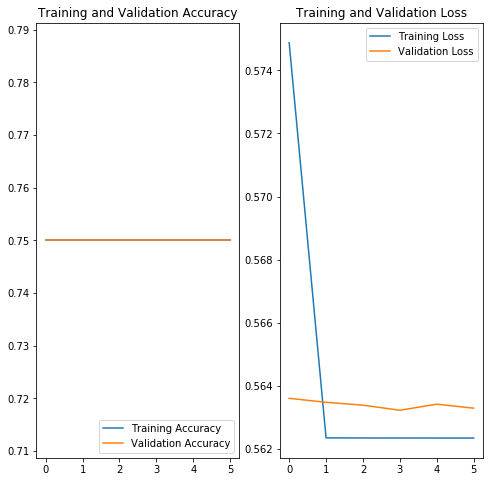

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()